# Introduction: PseMix Walkthrough

PseMix (pseudo-bag mixup) contains two key steps:
- **generating pseudo-bags**（`Step 1`; [its notebook](https://github.com/liupei101/PseMix/blob/main/notebooks/psemix_walkthrough_step1_pseudo_bag_generation.ipynb)),
- **mixing pseudo-bags**（`Step 2`; [its notebook](https://github.com/liupei101/PseMix/blob/main/notebooks/psemix_walkthrough_step2_pseudo_bag_mixup.ipynb)).

This notebook aims to help you get started with ***Step 1: Pseudo-bag Generation***. 

First of all, load required packages

In [ ]:
import os
import os.path as osp
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

os.chdir("..")
os.getcwd()

# Step 1: Pseudo-bag Generation

It contains two sub-steps:

- **Phenotype clustering** (`Step 1.1`) by
  - bag-prototype-based instance clustering (`Step 1.1 (a)`)
  - cluster fine-tuning (`Step 1.1 (b)`)
- **Phenotype-stratified sampling** (`Step 1.2`)

These steps have been implemented in our PseMix repo. You can directly use the following codes:
```python
from utils.io import read_patch_data
from utils.core import PseudoBag

NUM_CLUSTER = 8 # the number of clusters
NUM_PSEB = 30 # the number of pseudo-bags
NUM_FT = 8 # # fine-tuning times

# load WSI features
full_path = "./wsi_feats/feat_wsi_A_TCGA_3C_AALI.pt"
bag_feats = read_patch_data(full_path, dtype='torch').to(torch.float)

PB = PseudoBag(NUM_PSEB, NUM_CLUSTER, proto_method='mean', iter_fine_tuning=NUM_FT)

# label_pseudo_bag: the indicator of pseudo-bags
# pseudo_bags: a list of each pseudo-bag's features
label_pseudo_bag, pseudo_bags = PB.divide(bag_feats, ret_pseudo_bag=True)
```

---

**A detailed walkthrough**, mainly showing the details behind `PB.divide()`, will be given below. 

A WSI bag will be taken as the example for illustation: its feature file can be found at `./wsi_feats/feat_wsi_A_TCGA_3C_AALI.pt`.

specify the settings for pseudo-bag generation

In [2]:
NUM_CLUSTER = 8 # the number of clusters
NUM_PSEB = 30 # the number of pseudo-bags
NUM_FT = 8 # # fine-tuning times

generate pseudo-bags using the class `PB = PseudoBag(NUM_PSEB, NUM_CLUSTER, proto_method='mean', iter_fine_tuning=NUM_FT)` in `utils/core.py`

In [3]:
from utils.io import read_patch_data
from utils.core import PseudoBag
from utils.func import seed_everything

seed_everything(42)

PB = PseudoBag(NUM_PSEB, NUM_CLUSTER, proto_method='mean', pheno_cut_method='quantile', iter_fine_tuning=NUM_FT)

[setup] seed: 42
ProtoDiv-based pseudo-bag dividing: n = 30, l = 8.


load bag features from file

In [4]:
full_path = "./wsi_feats/feat_wsi_A_TCGA_3C_AALI.pt"
bag_feats = read_patch_data(full_path, dtype='torch').to(torch.float)

print(f"[info] Instance number = {bag_feats.shape[0]}; feature dim = {bag_feats.shape[1]}.")

[info] Instance number = 5584; feature dim = 1024.


/home/lichangyong/code/PseMix/utils/io.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pdata = torch.load(path, map_location=torch.device('cpu'))


## Step 1.1 Phenotype clustering 

### Step 1.1 (a) bag-prototype-based instance clustering

calculate distance measures using the class member function `PB.measure_distance_from_prototype`

In [5]:
# mean-value-based bag prototype
PB.ptype = torch.mean(bag_feats, dim=0)

# normalize the bag prototype
PB.norm_ptype = F.normalize(PB.ptype, p=2, dim=-1)

# calculate the distance of all instances from the bag prototype (cosine distance)
dis, limits = PB.protodiv_measure_distance(bag_feats) # [N, ], tuple

dividing phenotype by quantile distances, one phenotype for one instance cluster

In [6]:
data = dis.cpu().numpy()

# using quantiles to divide instances into groups
bins = np.quantile(data, [i / NUM_CLUSTER for i in range(NUM_CLUSTER + 1)])
bins[0], bins[-1] = bins[0] - 1e-5, bins[-1] + 1e-5
init_label_phe = np.digitize(data, bins) - 1

init_label_phe = torch.LongTensor(init_label_phe).to(dis.device)

for c in range(NUM_CLUSTER):
    print("#instances in {}-th penotype".format(c), (init_label_phe == c).sum())

#instances in 0-th penotype tensor(698)
#instances in 1-th penotype tensor(698)
#instances in 2-th penotype tensor(698)
#instances in 3-th penotype tensor(698)
#instances in 4-th penotype tensor(698)
#instances in 5-th penotype tensor(698)
#instances in 6-th penotype tensor(698)
#instances in 7-th penotype tensor(698)


visualize the initial phenotypes using tSNE

In [7]:
# tSNE embeddings
tsne = TSNE()
X_embedded = tsne.fit_transform(bag_feats.cpu().numpy())

<Axes: >

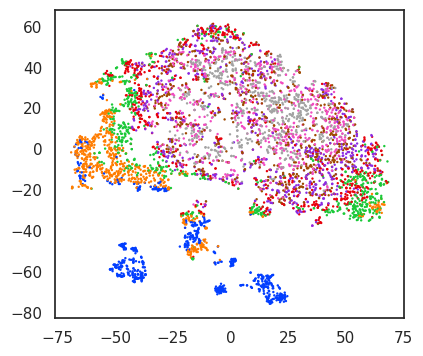

In [8]:
# visualize them with 2D plot
mpl.rc('pdf', fonttype=42)
plt.rcParams ["font.family"] = "serif"
plt.rcParams ["font.serif"] = ["Times New Roman"]

sns.set(style="white", font_scale=1.0) # white/dark/whitegrid/darkgrid/ticks
fig, ax = plt.subplots(figsize=(4.5,4))
palette = sns.color_palette("bright", NUM_CLUSTER)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=init_label_phe.cpu().numpy(), legend=False, 
                palette=palette, ax=ax, s=3, edgecolors='none', linewidths=0)
# plt.savefig("notebook/TSNE-phenotype.pdf", format='pdf', bbox_inches='tight')

### Step 1.1 (b) cluster fine-tuning

fine-tune the phenotype (clusters) using the class member function `PB.fine_tune_cluster`

In [9]:
# label_phe = PB.diem_clustering(bag_feats, init_label_phe)
label_phe = PB.protodiv_clustering(bag_feats)

for c in range(NUM_CLUSTER):
    print("#instances in {}-th penotype".format(c), (label_phe == c).sum())

#instances in 0-th penotype tensor(659)
#instances in 1-th penotype tensor(723)
#instances in 2-th penotype tensor(599)
#instances in 3-th penotype tensor(567)
#instances in 4-th penotype tensor(881)
#instances in 5-th penotype tensor(1038)
#instances in 6-th penotype tensor(719)
#instances in 7-th penotype tensor(398)


visualize the fine-tuned phenotypes

<Axes: >

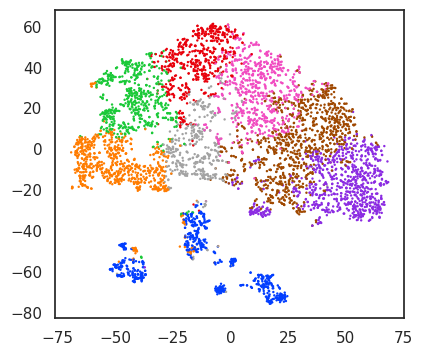

In [10]:
sns.set(style="white", font_scale=1.0) # white/dark/whitegrid/darkgrid/ticks
fig, ax = plt.subplots(figsize=(4.5,4))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=label_phe.cpu().numpy(), legend=False, 
                palette=palette, ax=ax, s=3, edgecolors='none', linewidths=0)
# plt.savefig("notebook/TSNE-phenotype-ft.pdf", format='pdf', bbox_inches='tight')

## Step 1.2 Phenotype-stratified sampling 

sample instances from each phenotype to obtain consistent pseudo-bags

In [11]:
label_psebag = torch.zeros_like(label_phe)

print("start phenotype-stratified sampling:")
for c in range(NUM_CLUSTER):
    c_size = (label_phe == c).sum().item()
    print(f"[info] randomly assign all the instances ({c_size}) from {c}-th phenotype to {NUM_PSEB} pseudo-bags.")
    label_psebag[label_phe == c] = PB.uniform_assign(c_size, NUM_PSEB).to(label_psebag.device)

print("\nStatistics of each pseudo-bag:")
pseudo_bags = []
for i in range(NUM_PSEB):
    cur_pseudo_bag = bag_feats[label_psebag == i]
    print(f"[info] the {i}-th pseudo-bag has {cur_pseudo_bag.shape[0]} instances.")
    pseudo_bags.append(cur_pseudo_bag)

start phenotype-stratified sampling:
[info] randomly assign all the instances (659) from 0-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (723) from 1-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (599) from 2-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (567) from 3-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (881) from 4-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (1038) from 5-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (719) from 6-th phenotype to 30 pseudo-bags.
[info] randomly assign all the instances (398) from 7-th phenotype to 30 pseudo-bags.

Statistics of each pseudo-bag:
[info] the 0-th pseudo-bag has 185 instances.
[info] the 1-th pseudo-bag has 186 instances.
[info] the 2-th pseudo-bag has 187 instances.
[info] the 3-th pseudo-bag has 187 instances.
[info] the 4-th pseudo-bag has 185 instances.
[info] the 5

`pseudo_bags` is a list of each pseudo-bag's features.